## This is the main calculation/analysis of the data that we have been scraping, storing, and loading. To see more

In [20]:
## Main Libraries
import pandas as pd

## Database
import sqlite3
from sqlite3 import Error as e

## Baseball
import mlbgame

## Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#### We get our data

In [2]:
## We get our data from the data warehouse
data_warehouse = r"C:\Users\arbis\Projects\nate_silver_gets_me_money\database\dk_538_games_dw.db" 
con = None
try:
    con = sqlite3. connect(data_warehouse)
except Error as e:
    print(e)

past_games = pd.read_sql_query("SELECT * FROM game_dw WHERE date(game_date) < date('now');", con)

con.close()

past_games.head()

,game_date,away_team,home_team,away_pct_538,home_pct_538,away_moneyline_dk,home_moneyline_dk
0,2021-09-08,Mariners,Astros,0.38,0.62,150,-170
1,2021-09-08,Giants,Rockies,0.58,0.42,-145,125
2,2021-09-08,Rangers,Diamondbacks,0.44,0.56,140,-160
3,2021-09-08,Twins,Indians,0.42,0.58,115,-135
4,2021-09-08,Tigers,Pirates,0.50,0.50,100,-120


#### We load in actual game outcome data using the mlbgame API

In [3]:
def get_scores(date_str):
    
    ## seperate our date
    date = date_str.split('-')
    year = int(date[0])
    month = int(date[1])
    day = int(date[2])
    
    ## get all of the games for that given day
    games = mlbgame.day(year,month,day)
    scores = [str(game) for game in games]
    scores_formatted = []

    ## the API has a reliable format, we can isolate our team names and scores through string splitting
    for score in scores:
        
        away = score.split(' at ')[0]
        home = score.split(' at ')[1]
    
        away_score = int(away.split(' ')[-1][1:-1])
        away_team = ' '.join(away.split(' ')[:-1])
    
        home_score = int(home.split(' ')[-1][1:-1])
        home_team = ' '.join(home.split(' ')[:-1])
    
        scores_formatted.append([date_str, away_team, home_team, away_score, home_score])
    
    ## return a list of lists
    return scores_formatted
    

In [4]:
## for every day where we have 538 percentage and DraftKing moneyline data:
past_games_scores_list = []
for date in past_games.game_date.unique():
    
    ## We get the scores for the day
    scores = get_scores(date)
    past_games_scores_list = past_games_scores_list + scores

## and turn it into a dataframe
past_games_scores = pd.DataFrame(past_games_scores_list,columns=["game_date","away_team","home_team","away_score","home_score"])
past_games_scores.head()

,game_date,away_team,home_team,away_score,home_score
0,2021-09-08,Mariners,Astros,8,5
1,2021-09-08,Giants,Rockies,7,4
2,2021-09-08,Rangers,D-backs,8,5
3,2021-09-08,Twins,Indians,3,0
4,2021-09-08,Tigers,Pirates,5,1


In [5]:
## We merge our past game dataframe with the scores dataframe
df = pd.merge(past_games, past_games_scores,  
                  how='right', 
                  left_on=['game_date','away_team', 'home_team'], 
                  right_on = ['game_date','away_team', 'home_team'])

df = df.dropna()

#### Lets start with seeing how many games draft kings and 538 predicted (not looking at magnitude)

In [6]:
## Lets build functions that gives percentages based off of a moneyline
def get_pct_from_moneyline(moneyline):
    
    moneyline = int(moneyline)
    
    ## If the moneyline is negative
    if moneyline < 0:
        
        pct = (-1 * moneyline) / ((-1 * moneyline) + 100)

    ## If the moneyline is positive
    elif moneyline > 0:
        
        pct = 100 / (moneyline + 100)

    pct = 100 * round(pct, 4)
    return pct

def asses_predictions_538(row):
    
    predicted_winner = ''
    actual_winner = ''
        
    ## we find which team 538 predicted to win
    if float(row['away_pct_538']) > float(row.home_pct_538):
        predicted_winner = 'away'
        
    elif float(row.away_pct_538) < float(row.home_pct_538):
        predicted_winner = 'home'
     
    ## and get the actual winner of that game
    if int(row["away_score"]) > int(row["home_score"]):
        actual_winner = 'away'
        
    elif int(row["away_score"]) < int(row["home_score"]):
        actual_winner = 'home'
     
    ## and check to see if 538 is correct
    if predicted_winner == actual_winner:
        return(1)
    
    elif predicted_winner != actual_winner:
        return(0)
    
def asses_predictions_dk(row):
    
    predicted_winner = ''
    actual_winner = ''
    
    ## we convert our moneylines into percentages
    away_pct = get_pct_from_moneyline(row.away_moneyline_dk)
    home_pct = get_pct_from_moneyline(row.home_moneyline_dk)
    
    ## we find which team DraftKings predicted to win
    if away_pct > home_pct:
        predicted_winner = 'away'
        
    if away_pct < home_pct:
        predicted_winner = 'home'

    ## and get the actual winner of that game        
    if int(row["away_score"]) > int(row["home_score"]):
        actual_winner = 'away'

    ## and check to see if DraftKings is correct
    elif int(row["away_score"]) < int(row["home_score"]):
        actual_winner = 'home'
        
    if predicted_winner == actual_winner:
        return(1)
    
    elif predicted_winner != actual_winner:
        return(0)
    
    
df['538_correct'] = df.apply(asses_predictions_538, axis = 1)
df['dk_correct'] = df.apply(asses_predictions_dk, axis = 1)

df.head()

,game_date,away_team,home_team,away_pct_538,home_pct_538,away_moneyline_dk,home_moneyline_dk,away_score,home_score,538_correct,dk_correct
0,2021-09-08,Mariners,Astros,0.38,0.62,150.0,-170.0,8,5,0,0
1,2021-09-08,Giants,Rockies,0.58,0.42,-145.0,125.0,7,4,1,1
3,2021-09-08,Twins,Indians,0.42,0.58,115.0,-135.0,3,0,0,0
4,2021-09-08,Tigers,Pirates,0.50,0.50,100.0,-120.0,5,1,0,0
5,2021-09-08,Mets,Marlins,0.51,0.49,-120.0,-110.0,1,2,0,0


In [7]:
print( "Draft kings predicted", df["dk_correct"].sum(), "of the", len(df), "games correctly")

print( "538 predicted", df["538_correct"].sum(), "of the", len(df), "games correctly")

print( "A random guess would predict", len(df)/2, "of the", len(df), "games correctly")


Draft kings predicted 85 of the 159 games correctly
538 predicted 84 of the 159 games correctly
A random guess would predict 79.5 of the 159 games correctly


Coin flipping is the new Meta

### Ultimatly, our goal isn't to predict more games that Draftkings, its to find games when DrafKings underesitmates a team's chance of winning (compared to 538) and gives the team an overly generous moneyline 

#### Lets see how much money we would have made over the past 59 games if we went with that betting strategy

In [8]:
def bet_outcome(bet, moneyline):
    
    moneyline = int(moneyline)
    
    ## if the moneyline is negative (betting favortie)
    if moneyline < 0:
        
        outcome = (bet * 100) / abs(moneyline)
        
    ## if the moneyline is positive (underdog)
    if moneyline > 0:
        
        outcome = (bet * moneyline) / 100

    outcome = bet + round(outcome , 2)
        
    return outcome

In [9]:
## then apply our odds function to our draftkings moneyline to get our draftkings raw probability percentage
df["raw_home_odds_dk"] = df["home_moneyline_dk"].apply(get_pct_from_moneyline)
df["raw_away_odds_dk"] = df["away_moneyline_dk"].apply(get_pct_from_moneyline)

## sports book odds add up to 100 + the padding percentage, or their estimated profit margin
df["dk_total_padding_val"] = df["raw_home_odds_dk"] + df["raw_away_odds_dk"] - 100

## This padding percentage is (THEORETICALLY) added equally on both sides, or at least in very close amounts
## We rescale the raw percentages back to a 100% total scale to get our final percentage
df["home_odds_dk"] = df["raw_home_odds_dk"] / (df["raw_home_odds_dk"] + df["raw_away_odds_dk"])
df["home_odds_dk"] = round(df["home_odds_dk"], 4)

df["away_odds_dk"] = df["raw_away_odds_dk"] / (df["raw_home_odds_dk"] + df["raw_away_odds_dk"])
df["away_odds_dk"] = round(df["away_odds_dk"], 4)

## We get our winnings columns by applying our bet_ouctome function to the original moneyline
df["winnings_on_1_dollar_home"] = df["home_moneyline_dk"].apply(lambda ml: bet_outcome(1, ml))
df["winnings_on_1_dollar_away"] = df["away_moneyline_dk"].apply(lambda ml: bet_outcome(1, ml))

## And get our expected outcome by multipling the winnings by the probability
df["expected_outcome_home_538"] = (df["winnings_on_1_dollar_home"] * df["home_pct_538"]) - 1
df["expected_outcome_away_538"] = (df["winnings_on_1_dollar_away"] * df["away_pct_538"]) - 1

df["adj_expected_outcome_away_538"] = df["winnings_on_1_dollar_away"] * (df["away_pct_538"] - df['dk_total_padding_val'] / 100 / 2) - 1
df["adj_expected_outcome_home_538"] = df["winnings_on_1_dollar_home"] * (df["home_pct_538"] - df['dk_total_padding_val'] / 100 / 2) - 1

df.head()

,game_date,away_team,home_team,away_pct_538,home_pct_538,away_moneyline_dk,home_moneyline_dk,away_score,home_score,538_correct,...,raw_away_odds_dk,dk_total_padding_val,home_odds_dk,away_odds_dk,winnings_on_1_dollar_home,winnings_on_1_dollar_away,expected_outcome_home_538,expected_outcome_away_538,adj_expected_outcome_away_538,adj_expected_outcome_home_538
0,2021-09-08,Mariners,Astros,0.38,0.62,150.0,-170.0,8,5,0,...,40.00,2.96,0.6115,0.3885,1.59,2.50,-0.0142,-0.0500,-0.087000,-0.037732
1,2021-09-08,Giants,Rockies,0.58,0.42,-145.0,125.0,7,4,1,...,59.18,3.62,0.4289,0.5711,2.25,1.69,-0.0550,-0.0198,-0.050389,-0.095725
3,2021-09-08,Twins,Indians,0.42,0.58,115.0,-135.0,3,0,0,...,46.51,3.96,0.5526,0.4474,1.74,2.15,0.0092,-0.0970,-0.139570,-0.025252
4,2021-09-08,Tigers,Pirates,0.50,0.50,100.0,-120.0,5,1,0,...,50.00,4.55,0.5218,0.4782,1.83,2.00,-0.0850,0.0000,-0.045500,-0.126632
5,2021-09-08,Mets,Marlins,0.51,0.49,-120.0,-110.0,1,2,0,...,54.55,6.93,0.4899,0.5101,1.91,1.83,-0.0641,-0.0667,-0.130109,-0.130281


In [10]:
## We take only the games with a positive adjusted expected outcome
games_to_bet_on = df.loc[(df['adj_expected_outcome_away_538'] > 0) | (df['adj_expected_outcome_home_538'] > 0)][["game_date", "away_team", "home_team", "away_pct_538", "home_pct_538", "away_moneyline_dk", "home_moneyline_dk", "adj_expected_outcome_away_538", "adj_expected_outcome_home_538"]]

## and combine it with our dataframe of actual outcomes
games_to_bet_on_w_scores = pd.merge(games_to_bet_on, past_games_scores,  
                  how='left', 
                  left_on=['game_date','away_team', 'home_team'], 
                  right_on = ['game_date','away_team', 'home_team'])


games_to_bet_on_w_scores.head()

,game_date,away_team,home_team,away_pct_538,home_pct_538,away_moneyline_dk,home_moneyline_dk,adj_expected_outcome_away_538,adj_expected_outcome_home_538,away_score,home_score
0,2021-09-08,Nationals,Braves,0.40,0.60,175.0,-210.0,0.043625,-0.142340,4,2
1,2021-09-08,Dodgers,Cardinals,0.50,0.50,-130.0,110.0,-0.151639,0.006530,4,5
2,2021-09-08,Angels,Padres,0.36,0.64,230.0,-290.0,0.111110,-0.173622,5,8
3,2021-08-31,Indians,Royals,0.53,0.47,100.0,-120.0,0.014500,-0.181532,7,2
4,2021-08-31,Pirates,White Sox,0.30,0.70,100.0,-120.0,-0.445500,0.239368,2,4


In [11]:
def actual_outcome(row):
    
    ## if the away team's expected bet outcome is greater than 0, we bet on it
    if row['adj_expected_outcome_away_538'] > 0:
        
        ## We check to see that the away team won
        if row['away_score'] > row['home_score']:
            
            ## if they won, return the bet payout plus the dollar bet
            outcome = bet_outcome(1, row['away_moneyline_dk'])
            return outcome
        
        ## if they dont win, you lost 1 dollar bet
        elif row['away_score'] < row['home_score']:
            return(-1)
        
    ## if the home team's expected bet outcome is greater than 0, we bet on it
    if row['adj_expected_outcome_home_538'] > 0:
    
        ## We check to see that the home team won
        if row['away_score'] < row['home_score']:
            
            ## if they won, return the bet payout plus the dollar bet
            outcome = bet_outcome(1, row['home_moneyline_dk'])
            return outcome
        
        ## if they dont win, you lost 1 dollar bet
        elif row['away_score'] > row['home_score']:
            return(-1)

games_to_bet_on_w_scores['payout'] = games_to_bet_on_w_scores.apply(actual_outcome, axis = 1)

print('Total Games over where I scraped the 538 percentages and DK moneylines:', len(df), '\n')
print('Total Games over where there is a theoretical positive betting outcome:', len(games_to_bet_on_w_scores), '\n')

print('Assuming we bet a dollar on each of those games:')
print("Total Payout:", games_to_bet_on_w_scores.payout.sum(), '\n')
print("Total Profit:", (games_to_bet_on_w_scores.payout.sum() - len(games_to_bet_on_w_scores)), '\n')
print("Total Profit per Game:", (games_to_bet_on_w_scores.payout.sum() - len(games_to_bet_on_w_scores)) / len(games_to_bet_on_w_scores))


Total Games over where I scraped the 538 percentages and DK moneylines: 159 

Total Games over where there is a theoretical positive betting outcome: 50 

Assuming we bet a dollar on each of those games:
Total Payout: 40.04 

Total Profit: -9.96 

Total Profit per Game: -0.19920000000000002


#### While there are some relativly significant payouts, there are too many losses (negative payouts) to make an overall profit

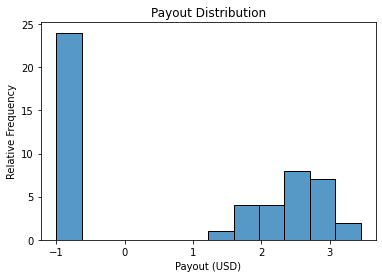

In [21]:
sns.histplot(games_to_bet_on_w_scores.payout, bins = 12)
plt.title('Payout Distribution')
plt.xlabel('Payout (USD)')
plt.ylabel('Relative Frequency')
plt.show()

## Right now, we were calculating the overall payout for all bests with a positive expected outcome. What happens if we use a higher threshold.

Instead of using every positive expected outcome, what if we only use expected outcomes greater than 0.025 (or higher)?

In [32]:
results_025 = games_to_bet_on_w_scores[(games_to_bet_on_w_scores['adj_expected_outcome_away_538'] >= 0.025) | (games_to_bet_on_w_scores['adj_expected_outcome_home_538'] >= 0.025)]
results_050 = games_to_bet_on_w_scores[(games_to_bet_on_w_scores['adj_expected_outcome_away_538'] >= 0.05) | (games_to_bet_on_w_scores['adj_expected_outcome_home_538'] >= 0.05)]
results_075 = games_to_bet_on_w_scores[(games_to_bet_on_w_scores['adj_expected_outcome_away_538'] >= 0.075) | (games_to_bet_on_w_scores['adj_expected_outcome_home_538'] >= 0.075)]
results_100 = games_to_bet_on_w_scores[(games_to_bet_on_w_scores['adj_expected_outcome_away_538'] >= 0.1) | (games_to_bet_on_w_scores['adj_expected_outcome_home_538'] >= 0.1)]

print('There are', games_to_bet_on_w_scores.shape[0], 'results when the threshold is 0 or greater')
print('There are', results_025.shape[0], 'results when the threshold is 0.025 or greater')
print('There are', results_050.shape[0], 'results when the threshold is 0.05 or greater')
print('There are', results_075.shape[0], 'results when the threshold is 0.075 or greater')
print('There are', results_100.shape[0], 'results when the threshold is 0.1 or greater')

There are 50 results when the threshold is 0 or greater
There are 31 results when the threshold is 0.025 or greater
There are 20 results when the threshold is 0.05 or greater
There are 16 results when the threshold is 0.075 or greater
There are 11 results when the threshold is 0.1 or greater


#### When the threshold is 0.025

In [62]:
print('When the threshold is 0.025 (Assuming we bet a dollar on each of these games):')
print("Total Games:", results_025.shape[0])
print("Wins:", sum(results_025['payout'] > 0))
print("Losses:", sum(results_025['payout'] < 0), '\n')

print("Payout Stats:")
print("Total Payout:", round(results_025.payout.sum(), 2))
print("Total Profit:", round((results_050.payout.sum() - len(results_025)), 2))
print("Total Profit per Game:", round((results_025.payout.sum() - len(results_025)) / len(results_025), 3))

When the threshold is 0.025 (Assuming we bet a dollar on each of these games):
Total Games: 31
Wins: 16
Losses: 15 

Payout Stats:
Total Payout: 28.37
Total Profit: -13.37
Total Profit per Game: -0.085


#### When the threshold is 0.05

In [61]:
print('When the threshold is 0.05 (Assuming we bet a dollar on each of these games):')
print("Total Games:", results_050.shape[0])
print("Wins:", sum(results_050['payout'] > 0))
print("Losses:", sum(results_050['payout'] < 0), '\n')

print("Payout Stats:")
print("Total Payout:", round(results_050.payout.sum(), 2))
print("Total Profit:", round((results_050.payout.sum() - len(results_050)), 2))
print("Total Profit per Game:", round((results_050.payout.sum() - len(results_050)) / len(results_050), 3))

When the threshold is 0.05 (Assuming we bet a dollar on each of these games):
Total Games: 20
Wins: 10
Losses: 10 

Payout Stats:
Total Payout: 17.63
Total Profit: -2.37
Total Profit per Game: -0.118


#### When the threshold is 0.075

In [60]:
print('When the threshold is 0.075 (Assuming we bet a dollar on each of these games):')

print("Total Games:", results_075.shape[0])
print("Wins:", sum(results_075['payout'] > 0))
print("Losses:", sum(results_075['payout'] < 0), '\n')

print("Payout Stats:")
print("Total Payout:", round(results_075.payout.sum(), 2))
print("Total Profit:", round((results_075.payout.sum() - len(results_075)), 2))
print("Total Profit per Game:", round((results_075.payout.sum() - len(results_075)) / len(results_075), 3))

When the threshold is 0.075 (Assuming we bet a dollar on each of these games):
Total Games: 16
Wins: 7
Losses: 9 

Payout Stats:
Total Payout: 10.18
Total Profit: -5.82
Total Profit per Game: -0.364


#### When the threshold is 0.1

In [59]:
print('When the threshold is 0.1 (Assuming we bet a dollar on each of these games):')

print("Total Games:", results_100.shape[0])
print("Wins:", sum(results_100['payout'] > 0))
print("Losses:", sum(results_100['payout'] < 0), '\n')

print("Payout Stats:")
print("Total Payout:", round(results_100.payout.sum(), 2))
print("Total Profit:", round((results_100.payout.sum() - len(results_100)), 2))
print("Total Profit per Game:", round((results_100.payout.sum() - len(results_100)) / len(results_100), 3))

When the threshold is 0.1 (Assuming we bet a dollar on each of these games):
Total Games: 11
Wins: 4
Losses: 7 

Payout Stats:
Total Payout: 3.93
Total Profit: -7.07
Total Profit per Game: -0.643


### This is weird, It seems like (given our limited data) the higher the expected payoff is, the lower the actual payout

To test this out, we try excluding rows where there is an expected payout of greater than 0.075

In [75]:
results_under_075 = games_to_bet_on_w_scores[((games_to_bet_on_w_scores['adj_expected_outcome_away_538'] < 0.1) & (games_to_bet_on_w_scores['adj_expected_outcome_away_538'] > 0)) \
                                             | ((games_to_bet_on_w_scores['adj_expected_outcome_home_538'] < 0.1) & (games_to_bet_on_w_scores['adj_expected_outcome_home_538'] > 0))]

print("Total Games:", results_under_075.shape[0])
print("Wins:", sum(results_under_075['payout'] > 0))
print("Losses:", sum(results_under_075['payout'] < 0), '\n')

print("Payout Stats:")
print("Total Payout:", round(results_under_075.payout.sum(), 2))
print("Total Profit:", round((results_under_075.payout.sum() - len(results_under_075)), 2))
print("Total Profit per Game:", round((results_under_075.payout.sum() - len(results_under_075)) / len(results_under_075), 3))

Total Games: 39
Wins: 22
Losses: 17 

Payout Stats:
Total Payout: 36.11
Total Profit: -2.89
Total Profit per Game: -0.074


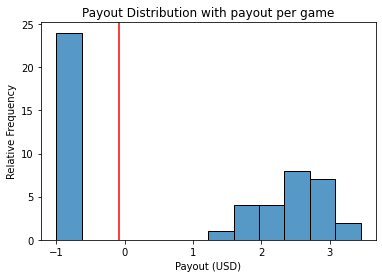

In [82]:

payout_per_game_total = (results_under_075.payout.sum() - len(results_under_075)) / len(results_under_075)

sns.histplot(games_to_bet_on_w_scores.payout, bins = 12)
plt.title('Payout Distribution with payout per game')
plt.xlabel('Payout (USD)')
plt.ylabel('Relative Frequency')
plt.axvline(payout_per_game_total, c = 'red')
plt.show()


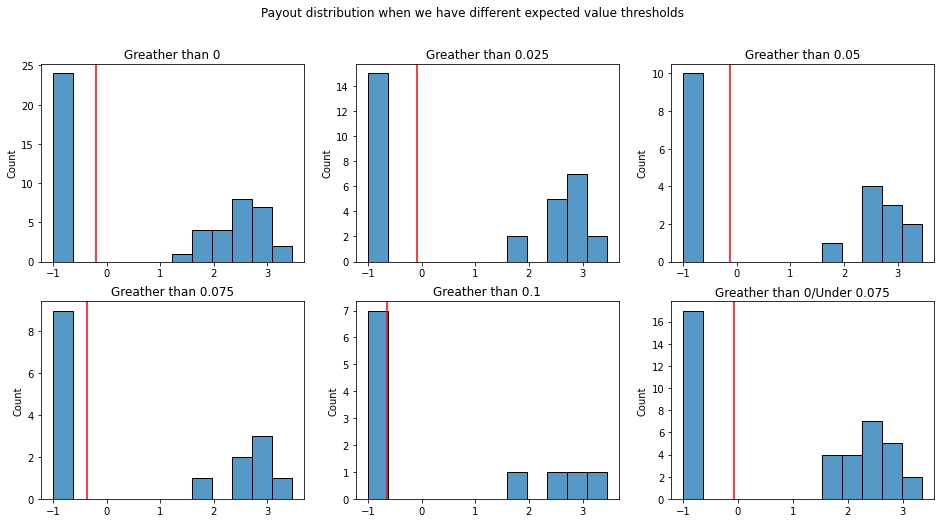

In [98]:
## We calculate payout_per_game
payout_per_game_full = (games_to_bet_on_w_scores.payout.sum() - len(games_to_bet_on_w_scores)) / len(games_to_bet_on_w_scores)
payout_per_game_025 = (results_025.payout.sum() - len(results_025)) / len(results_025)
payout_per_game_050 = (results_050.payout.sum() - len(results_050)) / len(results_050)
payout_per_game_075 = (results_075.payout.sum() - len(results_075)) / len(results_075)
payout_per_game_100 = (results_100.payout.sum() - len(results_100)) / len(results_100)
payout_per_game_u075 = (results_under_075.payout.sum() - len(results_under_075)) / len(results_under_075)


## Creating the plots
fig, axes = plt.subplots(2, 3, figsize=(16,8))
fig.suptitle('Payout distribution when we have different expected value thresholds')


## Greather than 0
sns.histplot(games_to_bet_on_w_scores.payout, bins = 12, ax=axes[0, 0])
axes[0, 0].axvline(payout_per_game_full, c = 'red')
axes[0, 0].set_title('Greather than 0')
axes[0, 0].set(xlabel=None)

## Greather than 0.025
sns.histplot(results_025.payout, bins = 12, ax=axes[0, 1])
axes[0, 1].axvline(payout_per_game_025, c = 'red')
axes[0, 1].set_title('Greather than 0.025')
axes[0, 1].set(xlabel=None)

## Greather than 0.05
sns.histplot(results_050.payout, bins = 12, ax=axes[0, 2])
axes[0, 2].axvline(payout_per_game_050, c = 'red')
axes[0, 2].set_title('Greather than 0.05')
axes[0, 2].set(xlabel=None)

## Greather than 0.075
sns.histplot(results_075.payout, bins = 12, ax=axes[1, 0])
axes[1, 0].axvline(payout_per_game_075, c = 'red')
axes[1, 0].set_title('Greather than 0.075')
axes[1, 0].set(xlabel=None)

## Greather than 0.1
sns.histplot(results_100.payout, bins = 12, ax=axes[1, 1])
axes[1, 1].axvline(payout_per_game_100, c = 'red')
axes[1, 1].set_title('Greather than 0.1')
axes[1, 1].set(xlabel=None)

## Greather than 0/Under 0.075
sns.histplot(results_under_075.payout, bins = 12, ax=axes[1, 2])
axes[1, 2].axvline(payout_per_game_total, c = 'red')
axes[1, 2].set_title('Greather than 0/Under 0.075')
axes[1, 2].set(xlabel=None)

plt.show()

# Conclusion:

With our limited data set, it seems like it is not possible to generating lasting profit solely off of comparing 538 baseball predictions against Draftkings' moneylines. When we try impose thresholds on expected outcome, it only appears to be worse. Clearly, Nate Silver isn't trying hard enough.

Overall, this was a fun exercise in web scraping, database building, and ETL. I am excited to see how this plays out with additional game data (assuming the 2022 lockout ends before the season starts).